a/r looking for fmax... DONE. fmax= 1.0
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 3.414213562373095
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 26.0
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Accept-rejecting DONE         
a/r looking for fmax... DONE. fmax= 0.3989422804014327
Accept-rejecting DONE         
Accept efficiency at 8 sigma 0.15682830437237313


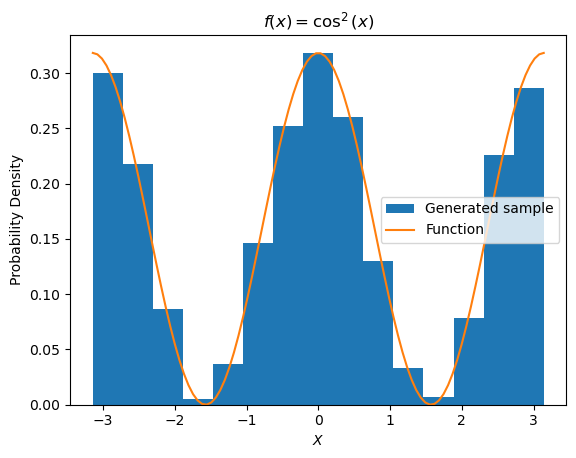

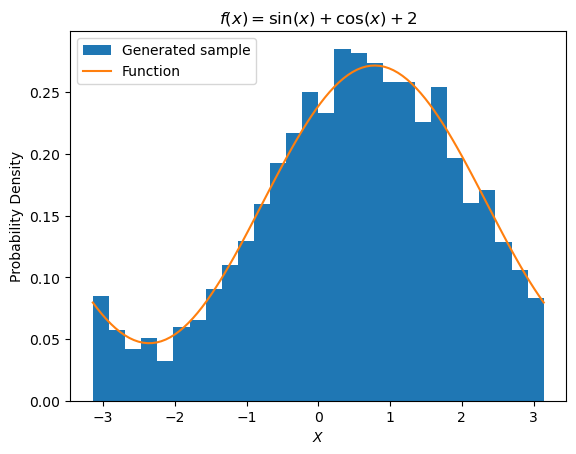

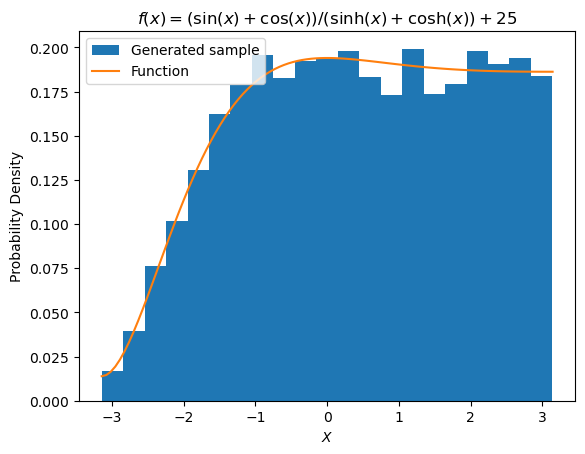

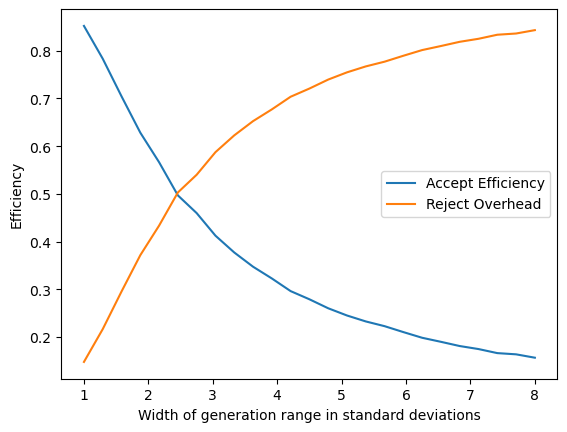

In [2]:
# Accept-reject generator that generates from 3 different functions 

import numpy as np
from scipy.optimize import brute, minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

def accept_reject_1d( func, xrange, size=1, fmax=None, ret_fmax=False, seed=None, stats=False ):
    """A simple function to run accept-reject generation.

    Parameters
    ----------
    func : callable
        A callable function which accepts one argument x and 
        returns the function which you want to generate from.
        Note that for accept-reject there is no requirement
        that is normalised
    xrange : tuple or list
        Must be a two element tuple or list containing the 
        range of x values to generate in
    size : int, optional
        Number of events to generate
    fmax : float, optional
        If already known you can provide the maximum value of
        the function. This speeds up generation a bit because
        the algorithm can skip finding the maximum
    stats : bool, optional
        If True then track the generation efficiency statistics
        and return them

    Returns
    -------
    x : array
        an array of generated x values
    fmax : float, optional
        if ret_fmax=True then will also return the fmax found
    stats : tuple, optional
        if stats=True will also return the accept_eff and reject_eff

    """
    
    if fmax is None:
        print('a/r looking for fmax... ', end='')
        # global
        f_to_min = lambda x: -func(x)
        x0 = brute( f_to_min, [xrange] )[0]
        # local
        x0 = minimize( f_to_min, x0=x0, bounds=[xrange] ).x[0]
        fmax = func(x0)
        print('DONE. fmax=', fmax)

    if seed is not None:
        np.random.seed(seed)

    res = []
    nrej = 0
    while len(res)<size:

        # generate uniform random in xrange
        x = np.random.uniform(*xrange)

        # compute the value of the func at this x
        fval = func(x)

        # check it's not negative
        if fval < 0:
            raise RuntimeError(f'Accept-reject found a negative function value. p.d.f.s cannot be negative. Bailing out')

        # check it's not bigger than fmax
        if fval > fmax:
            fmax = fval
            raise RuntimeError(f'Accept-reject found a larger function value than was provided {fval}. Updating fmax and bailing out')

        # now generate random between [0, fmax]
        ftest = np.random.uniform(0, fmax )

        # if ftest larger than fval reject else accept
        if ftest <= fval:
            res.append(x)
            print(f'Accept-rejecting {len(res)} / {size}', end='\r')
        # this just counts the number of rejections
        else:
            nrej += 1
    
    if stats:
        ntot = size + nrej
        rej_eff = nrej / ntot
        acc_eff = size / ntot
    
    print('Accept-rejecting DONE         ')
    if ret_fmax:
        if stats:
            return res, fmax, acc_eff, rej_eff
        else:
            return res, fmax
    else:
        if stats:
            return res, acc_eff, rej_eff
        else:
            return res

def check_ok_plot( func, xrange, dset, bins='auto', save=None, title=None ):

    # going to normalise the function numerically
    N = 1/quad( func, *xrange )[0]
    
    x = np.linspace(*xrange, 100)

    fig, ax = plt.subplots()
    ax.hist( dset, density=True, bins=bins, label='Generated sample')
    ax.plot(x, N*func(x), label='Function')
    ax.set_xlabel('$X$')
    ax.set_ylabel('Probability Density')
    ax.legend()
    
    if title is not None:
        ax.set_title( title )

    if save is not None:
        fig.savefig(save)

# Run some examples
if __name__=="__main__":
    
    xrange = [-np.pi, np.pi]

    functions = [
        lambda x: np.cos(x)**2,
        lambda x: np.sin(x) + np.cos(x) + 2,
        lambda x: ( np.sin(x) + np.cos(x) ) / ( np.sinh(x) + np.cosh(x) ) + 25
    ]

    names = [ r'$f(x) = \cos^2(x)$', 
              r'$f(x) = \sin(x) + \cos(x) + 2 $',
              r'$f(x) = ( \sin(x) + \cos(x) ) / ( \sinh(x) + \cosh(x) ) + 25$' ]

    files = [ 'cos2x', 'sinxcosx', 'sinxcosxosinhxcoshx' ]

    for func, name, file in zip(functions, names, files):

        dset = accept_reject_1d( func, xrange=xrange, size=5000 )
        check_ok_plot( func, xrange, dset, save=f'figs/accept_reject_{file}.pdf', title=name )

    # now check the efficiency for a normal distribution
    func = lambda x: (1/np.sqrt(2*np.pi)) * np.exp( -x**2 / 2 )

    acc_effs = []
    rej_effs = []
    sigmas = np.linspace(1,8,25)
    for sigma in sigmas:
        xrange = [ -sigma, sigma ]
        dset, acc_eff, rej_eff = accept_reject_1d( func, xrange, size=10000, stats=True )
        acc_effs.append( acc_eff )
        rej_effs.append( rej_eff )
    
    print('Accept efficiency at 8 sigma', acc_effs[-1])
    fig, ax = plt.subplots()
    ax.plot( sigmas, acc_effs, label='Accept Efficiency')
    ax.plot( sigmas, rej_effs, label='Reject Overhead')
    ax.set_xlabel('Width of generation range in standard deviations')
    ax.set_ylabel('Efficiency')
    ax.legend()
    fig.savefig('accept_reject_eff.pdf')
    plt.show()
